In [8]:
import torch
import skdim
import numpy as np
import pyroved as pv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

In [2]:
#generate data : np.array (n_points x n_dim). Here a uniformly sampled 5-ball embedded in 10 dimensions
data = np.zeros((1000,10))
data[:,:5] = skdim.datasets.hyperBall(n = 1000, d = 5, radius = 1, random_state = 0)

#estimate global intrinsic dimension
danco = skdim.id.DANCo().fit(data)
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):

#get estimated intrinsic dimension
print(danco.dimension_)

5.001747091371089


### Load in data

In [10]:
data = pd.read_csv('~/Desktop/columbia/capstone/fire-regimes/data/merged_data.csv')

df_dedup = data.groupby(['time', 'x', 'y', 'level'], as_index=False).mean()
df_pivoted = df_dedup.set_index(['time', 'y', 'x', 'level']).unstack('level')

df_pivoted.columns = [f'{level}-{var}' for var, level in df_pivoted.columns]
df = df_pivoted.reset_index().drop(columns=['time','y','x'])

X = df[~np.isnan(df).any(axis=1)]
X = normalize(X,axis=0)

In [11]:
train_data = torch.from_numpy(X).float()
train_loader = pv.utils.init_dataloader(train_data, batch_size=64)

In [12]:
in_dim = (174,)
vae = pv.models.iVAE(in_dim, latent_dim=4, invariances=None, seed=0)
trainer = pv.trainers.SVItrainer(vae)

In [13]:
for e in range(4):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1.2279
Epoch: 2 Training loss: 1.0189
Epoch: 3 Training loss: 1.0186
Epoch: 4 Training loss: 1.0184


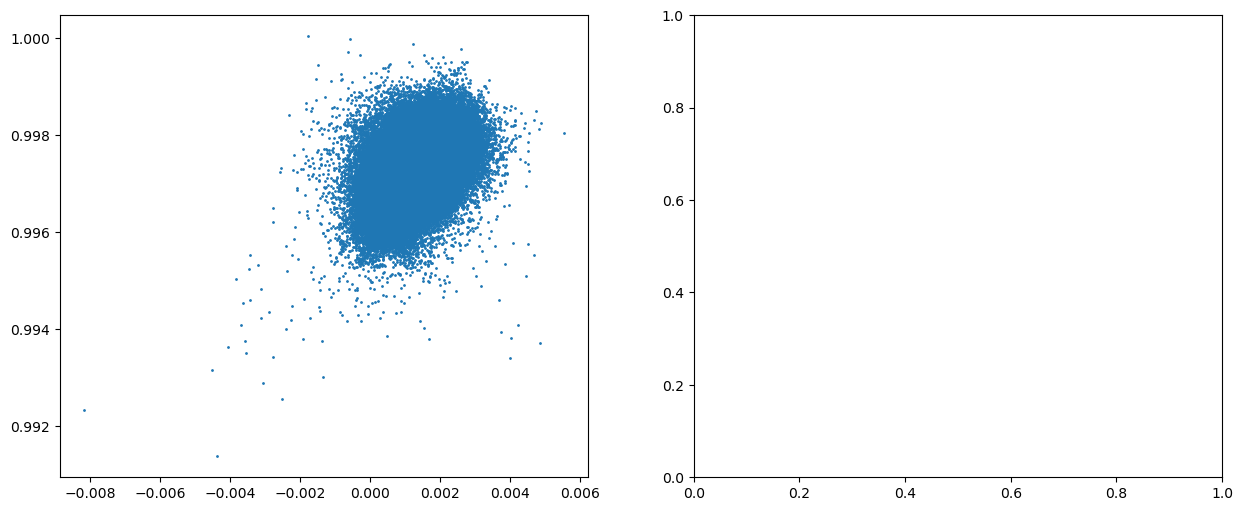

In [14]:
mean, log_var = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(mean[:, -1], log_var[:, -2], s=1)